In [200]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nepali-transaction-dataset/nepali_sensible_transactions_dataset.csv


In [201]:
dataframe = pd.read_csv('/kaggle/input/nepali-transaction-dataset/nepali_sensible_transactions_dataset.csv')

In [202]:
dataframe.head()

,transaction_id,date,amount,merchant,description,transaction_type,location,category
0,TXN00001,2025-04-07,6088.54,eSewa,Supermarket purchase,Debit,Biratnagar,Food & Groceries
1,TXN00002,2025-05-09,209.43,WorldLink,Electricity bill,Debit,Biratnagar,Bills & Utilities
2,TXN00003,2025-05-28,673.82,IME Pay,Uncategorized payment,Debit,Butwal,Others
3,TXN00004,2025-04-30,6001.56,Rastriya Banijya Bank,Apartment rent,Debit,Hetauda,Rent
4,TXN00005,2025-04-29,3190.98,Tootle,Bike ride,Debit,Pokhara,Transportation


# 1. Feature Engineering

## Removing unnecessary feature 
We will be removing unnecessary feature based on intiution which could be not very significant fir our model to train on (before further feature engineering)

In [203]:
# removed transaction_id and date since it has very less significance to our project
dataframe.drop(['transaction_id', 'date','location','transaction_type'], axis=1, inplace=True)
dataframe.head()

,amount,merchant,description,category
0,6088.54,eSewa,Supermarket purchase,Food & Groceries
1,209.43,WorldLink,Electricity bill,Bills & Utilities
2,673.82,IME Pay,Uncategorized payment,Others
3,6001.56,Rastriya Banijya Bank,Apartment rent,Rent
4,3190.98,Tootle,Bike ride,Transportation


# 2. Dataset Visualization

## Bar Graph

Category Distribution visualization

In [204]:
category_counts = dataframe["category"].value_counts()

print(category_counts)

category
Shopping             121
Others               116
Mobile Recharge      104
Rent                 103
Entertainment        100
Transportation        99
Education             96
Health & Medical      92
Bills & Utilities     91
Food & Groceries      78
Name: count, dtype: int64


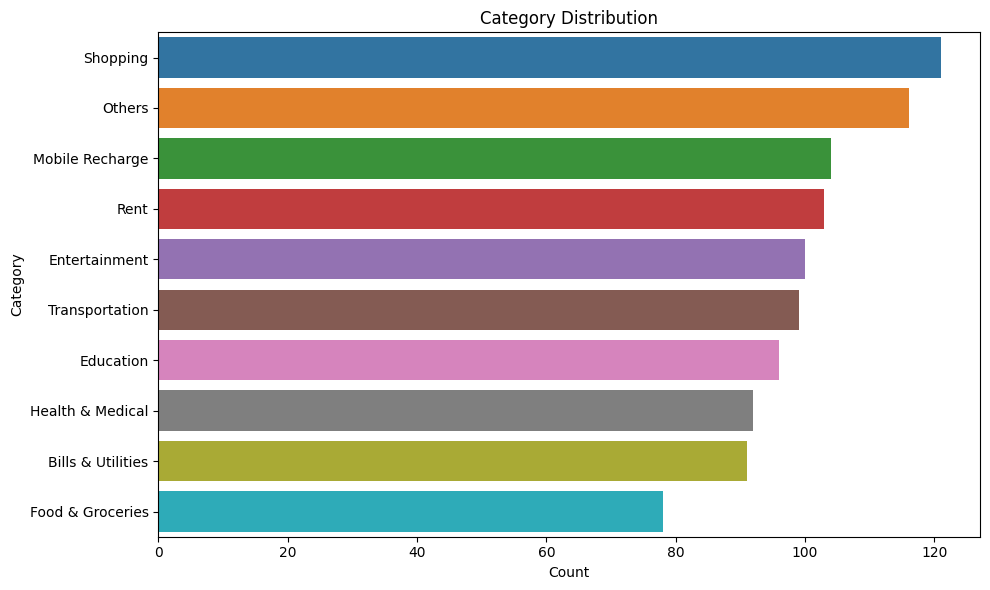

In [205]:
plt.figure(figsize=(10,6))
sns.countplot(data=dataframe, y='category', order=dataframe['category'].value_counts().index)
plt.title("Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

Looking at the graph above we can see the distribution of categories on our dataset with Shopping having the highest count if 121 followed by Others/uncategorized. Food & Groceceries have the least amount of appearance in the dataset with the count of 78. With the above chart we can visualize the distribution of different categories in the dataset for our model

## WordCloud : Top Words for all categories

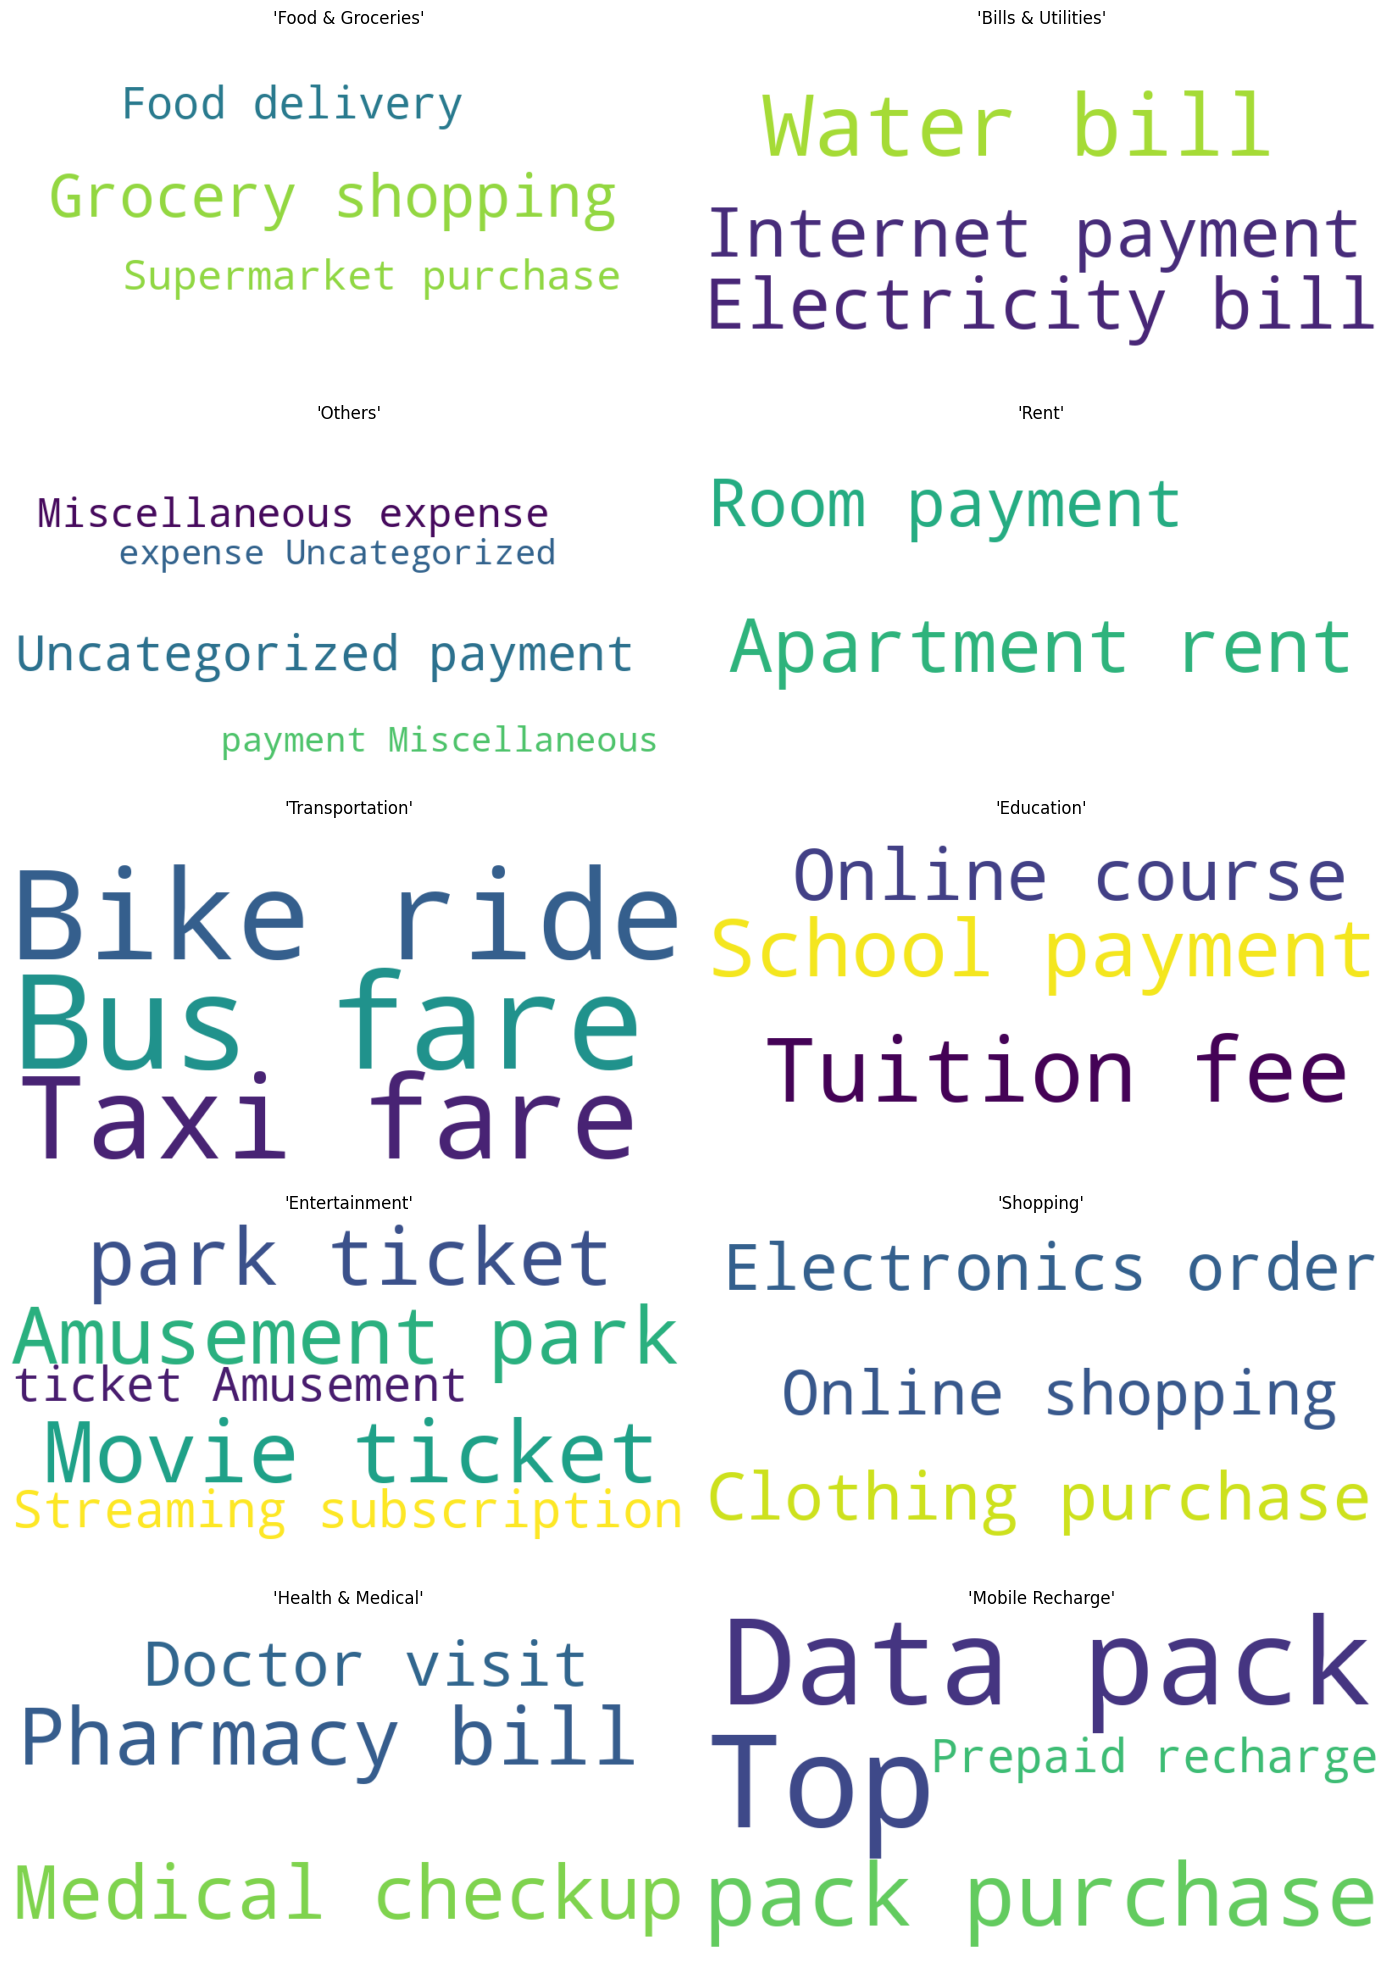

In [206]:
categories = df['category'].unique()
n = len(categories)

cols = 2
rows = (n + 1) // 2 

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))
axes = axes.flatten()

for i, cat in enumerate(categories):
    text = " ".join(df[df['category'] == cat]['description'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"'{cat}'", fontsize=12)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

From above wordcloud we can visualize top words used in the descripiton section in each of the categories.

## Top 10 words graph

Below chart shows top 10 words for the selected categories

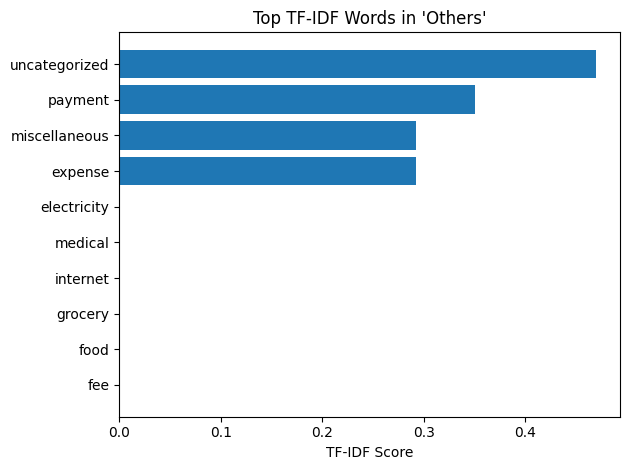

In [207]:
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['description'])

feature_names = np.array(vectorizer.get_feature_names_out())

target_category = 'Others' # This variable can be changed according to the liking for visualization
category_indices = df[df['category'] == target_category].index
category_tfidf = X_tfidf[category_indices].mean(axis=0)

top_indices = np.argsort(category_tfidf.A1)[-10:]  # top 10 words

plt.barh(feature_names[top_indices], category_tfidf[0, top_indices].A1)
plt.title(f"Top TF-IDF Words in '{target_category}'")
plt.xlabel("TF-IDF Score")
plt.tight_layout()
plt.show()


# Feature Engineering

In [208]:
# Drop any rows with missing key data
df = df.dropna(subset=["description", "merchant", "amount", "category"])

# seperating Features and labels
X = df[["description", "merchant", "amount"]]
y = df["category"]


In [209]:
# Train/test split with sklearn library with a split of 80% to 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Pipeline Creation

In [210]:
# Column transformer for preprocessing of data, takes in description as TF-IDF tokenizer, Encodes the merchants and scales the amount.
preprocessor = ColumnTransformer(
    transformers=[
        ("desc", TfidfVectorizer(), "description"),
        ('merchant', OneHotEncoder(handle_unknown='ignore'), ['merchant']),
        ("amount", StandardScaler(), ["amount"])
    ]
)

# Fit to the entire DataFrame, not just the column
X_transformed = preprocessor.fit_transform(df)

# Created Pipeline with preprocessor 
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Training and Prediction

In [211]:
# Training the model with randomforest classifier
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('desc', TfidfVectorizer(),
                                                  'description'),
                                                 ('merchant',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['merchant']),
                                                 ('amount', StandardScaler(),
                                                  ['amount'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [212]:
# Making predictions
y_pred = model_pipeline.predict(X_test)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

                   precision    recall  f1-score   support

Bills & Utilities       1.00      1.00      1.00        18
        Education       1.00      1.00      1.00        19
    Entertainment       1.00      1.00      1.00        20
 Food & Groceries       1.00      1.00      1.00        16
 Health & Medical       1.00      1.00      1.00        18
  Mobile Recharge       1.00      1.00      1.00        21
           Others       1.00      1.00      1.00        23
             Rent       1.00      1.00      1.00        21
         Shopping       1.00      1.00      1.00        24
   Transportation       1.00      1.00      1.00        20

         accuracy                           1.00       200
        macro avg       1.00      1.00      1.00       200
     weighted avg       1.00      1.00      1.00       200



# Evaluation

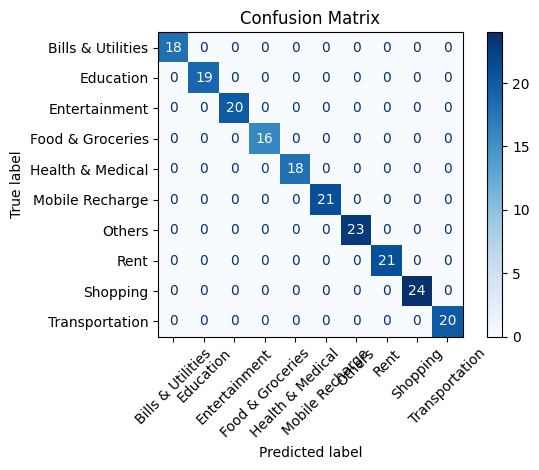

In [213]:
labels = model_pipeline.classes_

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=labels, xticks_rotation=45,
    cmap='Blues', colorbar=True
)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Testing

After our classification model is done we will try predicting with our custom unseen data (No UI just enter inputs here)

In [214]:

custom_input = pd.DataFrame([{
    "description": "expense",
    "merchant": "eSewa",
    "amount": 200.00
}])

prediction = model_pipeline.predict(custom_input)
vectorized_input = preprocessor.transform(custom_input)
# print(vectorized_input)
print("Predicted category:", prediction[0])


Predicted category: Others


# Conclusion